# Lab 4 Logistic Regression

Welcome to the world of Machine Learning!

In this lab course, we will build a multi-label classifier based on logistic regression and apply it to a small-scale but very popular dataset.

**Submission Requirement:**
1. Submit .ipynb notebook file including all the running results. Failed to do so will cause grade deduction.
2. Submit a lab report as a digital file (.pdf format is preferred) containing your descriptions, comments, and thoughts on code snippets that you think are important or of interest (not only the implemented tasks). This time I will provide more hints on potentially important parts, which are for reference only and are not necessary to be included in the report.

In [11]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [12]:
## download dataset
if not os.path.exists('Celebrity_Faces_Dataset'):
    remote_path = 'https://github.com/Michigan-State-University-CSE-440/logistic-regression/releases/download/v1.0/Celebrity_Faces_Dataset.zip'
    local_path = 'Celebrity_Faces_Dataset.zip'
    if not os.path.exists(local_path):
        os.system(f'wget {remote_path}')
    os.system(f'unzip {local_path}')

## Part 1: Celebrity Faces Dataset
This dataset consists of facial images of 17 different celebrities, each includes 100 images. The images are typically sourced from public datasets or collected from online media, ensuring a diverse range of facial expressions, lighting conditions, and angles.

**Key Features:**
- Total Celebrities: 17
- Images per Celebrity: 100
- Total Images: 1,700
- Variation: Contains different facial poses, lighting conditions, and minor occlusions.
- Annotation: Each image is annotated with one label (name of a celebrity) which can be accessed by the name of the corrosponding folder.

**Dataset Folder Organization:**
```
Celebrity_Faces_Dataset
  -Celebrity Name_1
    -Image_1_Name.Png
    -Image_2_Name.Png
    -...
  -Celebrity Name_2
    -Image_1_Name.Png
    -Image_2_Name.Png
    -...
  -...
```

Following is the visualizaiton of some images in the dataset:

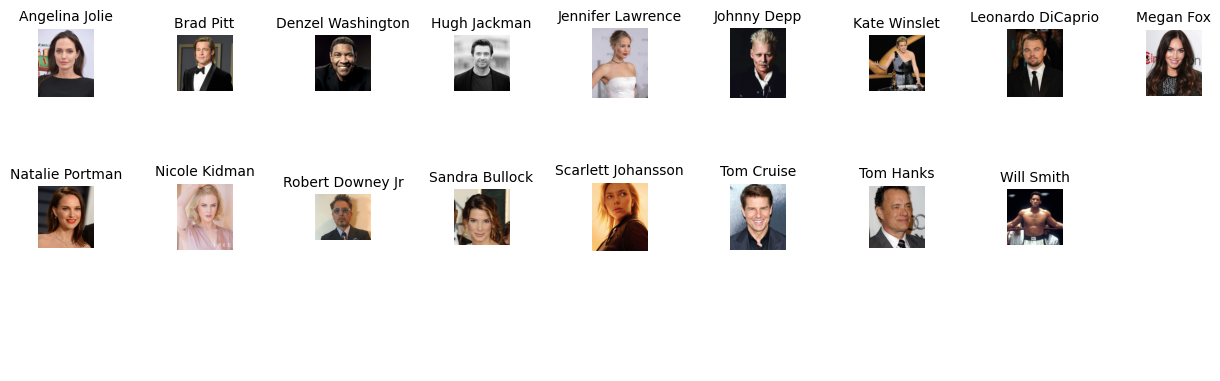

In [13]:
root_dir = 'Celebrity_Faces_Dataset'
celebrity_names = sorted(os.listdir(root_dir))  # Ensure consistent ordering

rows, cols = 2, 9
fig, axs = plt.subplots(rows, cols, figsize=(15, 6))  # Adjust figure size for better spacing
# Iterate over celebrity folders
for i, name in enumerate(celebrity_names):
    if i >= rows * cols:  # Prevent out-of-bounds errors
        break
    # Read the first image of each celebrity
    img_path = os.path.join(root_dir, name, os.listdir(os.path.join(root_dir, name))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    row, col = divmod(i, cols)
    axs[row, col].imshow(img)
    axs[row, col].set_title(name, fontsize=10)
    axs[row, col].axis('off')

# Hide empty subplots
for i in range(rows * cols):
    if i >= len(celebrity_names):
        row, col = divmod(i, cols)
        axs[row, col].axis('off')
# Adjust spacing
plt.subplots_adjust(wspace=1.5, hspace=-0.5)  # Increased horizontal and vertical spacing
# Show plot
plt.show()

### Task 1: Load Image Data
In this task, you need to load all the images and assign them a corrosponding label. You may refer to the above visualization code to use OPENCV (cv2) python package for reading the images, but for this task you also need to do some pro-processings to the raw images, ensuring they can be smoothly used as the input of model.

Learning Resources about the Usage of OPENCV:
1. (official doc) https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html
2. https://www.geeksforgeeks.org/opencv-python-tutorial/
3. https://www.youtube.com/watch?v=kSqxn6zGE0c
4. https://www.youtube.com/watch?v=oXlwWbU8l2o


In [14]:
def load_celebrity_faces(root_dir='Celebrity_Faces_Dataset', image_size=(64, 64)):
    """
    Loads images from subfolders of `root_dir` (one folder per celebrity).
    Returns:
        X_gray: Flattened grayscale images for training, shape (num_samples, H*W).
        y:      Label array, shape (num_samples,).
        label_map: {label_idx: 'celebrity_name'}.
        X_color:  Color images (resized but not converted to grayscale),
                  shape (num_samples, H, W, 3) in RGB order for display.
    """
    X_gray = []
    X_color = []
    y = []

    # subfolders = celebrity names
    classes = sorted([
        d for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ])

    ########################### Potentially Important: Name to Label Mapping ###########################
    ## In machine learning algorithms, text cannot be used directly as a label because it cannot be converted to an one-hot encoding
    ## (e.g., 1-> 010000, 5-> 000001). Therefore, we map each unique text to a unique numerical value (e.g., "Angelina Jolie"->0, "Brad Pitt"->1)
    ## and use that numerical value as the label.
    label_map = {idx: celeb for idx, celeb in enumerate(classes)}
    name_to_label = {celeb: idx for idx, celeb in enumerate(classes)}
    ###################################################################################################

    for celeb_name in classes:
        celeb_label = name_to_label[celeb_name]
        celeb_folder = os.path.join(root_dir, celeb_name)
        for i, filename in enumerate(os.listdir(celeb_folder)):
            filepath = os.path.join(celeb_folder, filename)

            ######TODO:Read color image img_bgr from filepath######
            img_bgr = cv2.imread(filepath)
            #######################################################

            ######TODO:Process color image img_bgr for result visualization######
            # step 1: resize the image to 256*256
            img_bgr_vis = cv2.resize(img_bgr, (256, 256))
            ######################################################################
            # step 2: switch the order of color channel from BGR to RGB
            img_rgb_vis = cv2.cvtColor(img_bgr_vis, cv2.COLOR_BGR2RGB)

            ######TODO:Process color image img_bgr for model training######
            # step 1: resize the image based on the input image_size
            img_bgr = cv2.resize(img_rgb_vis, image_size)
            # step 2: convert the image to grayscale, and flatten it to a 1D array
            img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).reshape(-1)
            ##########################################################################

            X_color.append(img_rgb_vis)
            X_gray.append(img_gray)
            y.append(celeb_label)

    X_color = np.array(X_color, dtype=np.uint8)  # shape: (num_samples, H, W, 3)
    X_gray = np.array(X_gray, dtype=np.float32)  # shape: (num_samples, H*W)
    y = np.array(y, dtype=np.int32)

    return X_gray, y, label_map, X_color


Validate the data loading function. The expected results should be 1700 samples in 17 classes.

In [15]:
print('Data Statistics:')
X_gray, y, label_map, X_color = load_celebrity_faces()
print("Number of samples:", len(X_gray))
print("Number of classes:", len(label_map))

Data Statistics:
Number of samples: 1700
Number of classes: 17


### Task 2: K-folds Cross-validation
K-fold cross-validation is a very classical technique used to evaluate machine learning models by splitting the dataset into K folds. In the case of multi-class classification, this ensures that images from each class are evenly distributed across the folds.

**How It Works:**
1. Partition the Dataset: Each class's images are divided into K equal parts (folds).
2. Iterate K Times: For each iteration, one fold from each class is selected as the test sample for this category, and the test samples from all the classes are combined as the test data. Similarly, the remaining K-1 folds of each class are combined and used as the training data.
3. The model should be **initalized and trained independently on each iteration**, thus we can calculate the classification accuracy for each iteration. The final accuracy is the average of all the accuracies over K iterations.

In this task, you need to complete some key steps of K-folds data splitting so that the resulting data can be used for subsequent model training as well as cross-validation. Following is a detailed **Guideline for TODO part**:
1. Initialize label_folds: A dictionary to store K folds for each class. (Already provided, no need to repeat this)
2. Loop Through Each Class:
   - Get the list of sample indices for the class using *label_indices_map*.
   - Compute fold_sizes, ensuring that each fold gets an even share.
3. Create Folds:
   - Use a loop to slice the indices based on fold_sizes.
   - Store each subset in label_folds.
4. The resulting *label_folds* should be a dictionary where each *key* is a label, the corrosponding *value* is a list of folds, and each fold is a numpy array, i.e.,
``label_folds = {0: [array_1, ..., array_k], 1: [array_1, ..., array_k], ..., K: [array_1, ..., array_k]}``

In [16]:
def kfold_split(X, y, k=5, classes=17):
    """
    Splits the dataset into k folds for cross-validation.
    Args:
        X: Input features, shape (num_samples, num_features).
        y: Labels, shape (num_samples,).
        k: Number of folds.
    Returns:
        folds: List of k tuples, each containing (train_indices, test_indices).
    """
    assert len(X) == len(y), "X and y must have same length."

    label_indices_map = {}

    ########################### Potentially Important: Gather Indices by Label ###########################
    ## you may check the usage of np.where() function and figure out what's going on here, and think about
    ## how it helps split the data of each class into k folds.
    for label in range(classes):
        label_indices = np.where(y == label)[0]
        label_indices_map[label] = label_indices
    ####################################################################################################

    label_folds = {}
    #######TODO: partition each label's indices into k folds######
    #Step one: Loop through the label_indices_map and computing the fold_sizes
    #https://numpy.org/devdocs/reference/generated/numpy.full.html
    for label, values in label_indices_map.items():

# https://numpy.org/doc/2.1/reference/random/generated/numpy.random.shuffle.html
      np.random.shuffle(values)

      fold_sizes = np.full(k, len(values) // k, dtype= int)

      folds_for_label = []
      current = 0
      for fold_size in fold_sizes:
          fold_indices = values[current:current + fold_size]
          folds_for_label.append(fold_indices)
          current += fold_size

      label_folds[label] = folds_for_label

    ##############################################################

    ######Potentially Important: combine folds across labels #######
    ## Figure out how the indices are combined across labels to
    ## form the final k folds.
    folds = []
    for i in range(k):
        test_indices_list = []
        train_indices_list = []
        for label in range(classes):
            # i-th subset for label -> test
            test_indices_list.append(label_folds[label][i])
            # other subsets -> train
            for j in range(k):
                if j != i:
                    train_indices_list.append(label_folds[label][j])

        test_indices = np.concatenate(test_indices_list)
        train_indices = np.concatenate(train_indices_list)
        folds.append((train_indices, test_indices))
    ##############################################################

    return folds

Now we are going to use the following code to verify our implementation of the K-folds data splitting. The expected output figure is shown below for reference:
![image](https://github.com/Michigan-State-University-CSE-440/logistic-regression/blob/main/assets/k_fold_vis.png?raw=1)

Shape of X_dummy: (1700, 1)
Shape of y_dummy: (1700,)


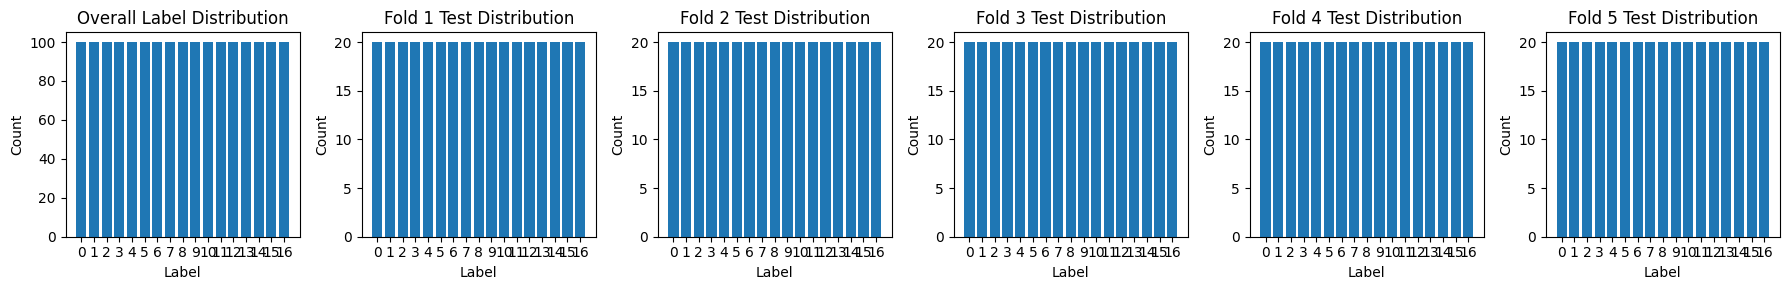

In [17]:
# ------------------------------
# Create a dummy dataset.
# ------------------------------
X_dummy = np.arange(1700).reshape(1700, 1)  # Dummy features.
y_dummy = np.repeat(np.arange(17), 100)  # Dummy labels.
print("Shape of X_dummy:", X_dummy.shape)
print("Shape of y_dummy:", y_dummy.shape)

# Generate the folds.
folds = kfold_split(X_dummy, y_dummy, k=5)

# ------------------------------
# Visualization of Data Distribution.
# ------------------------------
unique_labels = np.unique(y_dummy)
overall_counts = np.bincount(y_dummy, minlength=len(unique_labels))

# Create a figure with one extra subplot for overall distribution.
fig, axes = plt.subplots(1, len(folds) + 1, figsize=(18, 3))

# Overall distribution plot.
axes[0].bar(unique_labels, overall_counts, tick_label=unique_labels)
axes[0].set_title("Overall Label Distribution")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")

# Plot test set label distribution for each fold.
for i, (_, test_idx) in enumerate(folds, 1):
    test_counts = np.bincount(y_dummy[test_idx], minlength=len(unique_labels))
    axes[i].bar(unique_labels, test_counts, tick_label=unique_labels)
    axes[i].set_title(f"Fold {i} Test Distribution")
    axes[i].set_xlabel("Label")
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Part 2: Logistic Regression
This part focuses on the implementation of logistic regression (LR). LR is a statistical model used for classification tasks. It predicts the probability of an instance belonging to a particular class by applying the sigmoid function to a linear combination of input features. For binary classification, it outputs probabilities between 0 and 1, assigning the instance to the class with the higher probability.

To extend logistic regression for multi-class classification, we use the softmax function, which generalizes the binary logistic regression model to handle multiple classes simultaneously. Softmax-based logistic regression is commonly used in machine learning, particularly for multi-class classification tasks. Softmax function is essentially a maximum likelihood estimation. Recall what we learnt in class, the softmax function can be represented by

<img src="https://github.com/Michigan-State-University-CSE-440/logistic-regression/blob/main/assets/softmax.png?raw=1" alt="softmax" width="500"/>

Instead of computing a single probability for a binary outcome, softmax outputs a probability distribution over all possible classes. In this approach, we define a separate linear function for each class, computing a raw score (logit, which is ``w*f(x)`` in this side) for each category. The softmax function then converts these logits into 0-1 probabilities by exponentiating each logit and normalizing by the sum of exponentiated logits across all classes. This ensures that the predicted probabilities sum to 1.

During training, the model optimizes the deviation between predicted probability with one-hot encoding, which measures how well the predicted probability distribution aligns with the true labels. During testing, the class with the highest probability is chosen as the final prediction.

Learning Resources about Softmax function:
1. https://www.pinecone.io/learn/softmax-activation/
2. https://en.wikipedia.org/wiki/Softmax_function
3. https://www.geeksforgeeks.org/the-role-of-softmax-in-neural-networks-detailed-explanation-and-applications/
4. https://www.youtube.com/watch?v=8ah-qhvaQqU

### Task 3: Logistic Regression Implmentation
In this task, you need to implement some key steps of LR. The optimization through gradient descent is fully provided, but you need to try to understand it and **include your understanding of the optimization in you report**.

Learning Resources about Gradient descent:
1. https://www.youtube.com/watch?v=sDv4f4s2SB8
2. https://www.youtube.com/watch?v=qg4PchTECck

In [18]:
class MultiClassLogisticRegression:
    def __init__(self, learning_rate=0.01, num_epochs=1000, batch_size=64, seed=42):
        """
        Initialize the logistic regression model.

        Parameters:
          learning_rate: Step size for gradient descent.
          num_epochs: Number of epochs to train.
          batch_size: Size of mini-batches.
          seed: Random seed for reproducibility.
        """
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.seed = seed
        self.W = None  # Weight matrix will be initialized later

    def softmax(self, logits):
        """
        Compute the softmax of the logits.
        Args:
            logits: Array of shape (n_samples, n_classes).
        Returns:
            Array of shape (n_samples, n_classes) where each row sums to 1.
        """

        ############TODO:Implement the softmax function following the equation############
        ## Hint: Remember to subtract np.max(logits, axis=1, keepdims=True) before exponentiating.


        softmax_output = np.exp(logits - np.max(logits, axis=1, keepdims=True)) / np.sum(np.exp(logits - np.max(logits, axis=1, keepdims=True)), axis=1, keepdims=True)
        ##################################################################################

        return softmax_output

    def one_hot(self, y, num_classes):
        """
        Convert integer labels to one-hot vectors.
        Args:
            y: Array of shape (n_samples,) with integer labels.
            num_classes: Number of classes.
        Returns:
            Array of shape (n_samples, num_classes) with one-hot encoding.
        """

        ############TODO: Implement one-hot encoding for the label vector y############
        ## Hint: Create a zero matrix of shape (number_of_samples, num_classes) and set the appropriate indices to 1.
        one_hot_encoded = np.zeros((len(y), num_classes))

        for i, label in enumerate(y):
          one_hot_encoded[i, label] = 1
        ##############################################################################

        return one_hot_encoded

    def initialize_weights(self, num_features, num_classes):
        """
        Initialize the weight matrix with small random values.
        """
        rng = np.random.default_rng(self.seed)
        self.W = rng.normal(loc=0.0, scale=0.01, size=(num_features, num_classes))

    def fit(self, X, y):
        """
        Train the model using mini-batch gradient descent.

        Parameters:
          X: Input feature matrix of shape (n_samples, n_features).
          y: Array of labels of shape (n_samples,).
        """
        n_samples, num_features = X.shape
        num_classes = len(np.unique(y))
        self.initialize_weights(num_features, num_classes)

        for epoch in range(self.num_epochs):
            # Shuffle the data using np.random.permutation.
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Process mini-batches
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuffled[start:end]   # shape: (batch_size, num_features)
                y_batch = y_shuffled[start:end]   # shape: (batch_size,)

                ###########TODO: Implement the calculation of probabilities###########
                ## step 1: Compute the logits (linear combination of inputs and weights)
                ## using dot multiplication between matrices X_batch and self.W
                logits = np.dot(X_batch,self.W)
                ## step 2: Call the softmax function to get probabilities
                probs = self.softmax(logits)
                ## step 3: Call the one-hot function to encode labels
                y_one_hot =  self.one_hot(y_batch, num_classes)
                ######################################################################

                ####Potentially Important: Gradient Calculation and Gradient Descent####
                ce_loss = -np.sum(y_one_hot * np.log(probs + 1e-15)) / self.batch_size
                grad = np.dot(X_batch.T,probs - y_one_hot) / X_batch.shape[0]
                self.W -= self.learning_rate * grad
                ######################################################################

    def predict(self, X):
        """
        Predict class labels for input data.
        Args:
            X: Input feature matrix of shape (n_samples, n_features).
        Returns:
            Array of predicted labels of shape (n_samples,).
        """
        #########################TODO: label prediction#########################
        ## step 1: Compute the logits similar to the fit function
        logits = np.dot(X,self.W)
        ## step 2: Apply the softmax function to get probabilities
        probs = self.softmax(logits)
        ## step 3: Select the index with the highest probability for each sample as the label prediction
        pred = np.argmax(probs, axis=1)
        ##########################################################################

        return pred


## Part 3: Multi-class Classification (No Task)
Finally, we can achieve the multi-class classification by putting everthing we have done together, including the data curation and modeling, to form a complete pipeline.

In [19]:
root_dir = "Celebrity_Faces_Dataset"
seed=440
# below are some hyperparameters, you can feel free to change them
# and see how they affect the model performance
k=5
pca_components=100
learning_rate=0.01
num_epochs=200
batch_size=128

In [20]:
# 1. Load data
X_gray, y, label_map, X_color = load_celebrity_faces(root_dir, image_size=(64, 64))
print(f"Loaded {len(X_gray)} images for {len(label_map)} celebrities.\n")

# 2. Normalize grayscale features to [0..1] for training
X_gray = X_gray / 255.0

# 3. Perform manual k-fold splitting
folds = kfold_split(X_gray, y, k=k)

accuracies = []

## these three parameters are used to store the data for visualizing the classirication results,
## no need to pay much attention to them
last_y_test = None
last_y_pred = None
last_test_indices = None

fold_num = 1
for train_indices, test_indices in folds:
    print(f"=== Fold {fold_num}/{k} ===")
    fold_num += 1

    ## get the training and testing data based on the indices
    X_train = X_gray[train_indices]
    y_train = y[train_indices]
    X_test = X_gray[test_indices]
    y_test = y[test_indices]

    #########Potentially Important: Apply PCA to the image#########
    ## PCA is used for Dimensionality Reduction and Feature Extraction, which
    ## can help to reduce the computational cost and improve the model performance
    pca = PCA(n_components=pca_components, random_state=seed)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    ############################################################

    # 4. initalize and train logistic regression model
    model = MultiClassLogisticRegression(
        learning_rate,
        num_epochs,
        batch_size,
        seed
    )
    model.fit(X_train, y_train)

    # 5. Evaluate on the testing data
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

    print(f"Fold accuracy: {accuracy*100:.2f}%\n")

    # keep data for final fold visualization
    last_y_test = y_test
    last_y_pred = y_pred
    last_test_indices = test_indices

# 6. Print results across folds
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
print(f"=== {k}-Fold Final Results ===")
print("Accuracies per fold:", [f"{acc*100:.2f}%" for acc in accuracies])
print(f"Mean accuracy: {mean_acc*100:.2f}%")
print(f"Std deviation: {std_acc*100:.2f}%")

Loaded 1700 images for 17 celebrities.

=== Fold 1/5 ===
Fold accuracy: 21.76%

=== Fold 2/5 ===
Fold accuracy: 20.59%

=== Fold 3/5 ===
Fold accuracy: 16.76%

=== Fold 4/5 ===
Fold accuracy: 15.88%

=== Fold 5/5 ===
Fold accuracy: 20.59%

=== 5-Fold Final Results ===
Accuracies per fold: ['21.76%', '20.59%', '16.76%', '15.88%', '20.59%']
Mean accuracy: 19.12%
Std deviation: 2.34%


## Part 4: Visualization (No Task)
In this part, we visualize some classification reults on the testing data. Don't be suprised with mistakes the model makes.

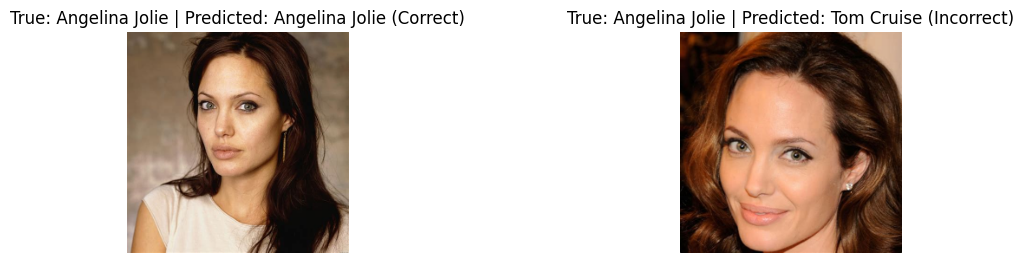

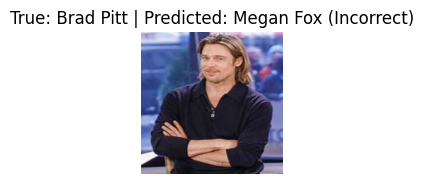

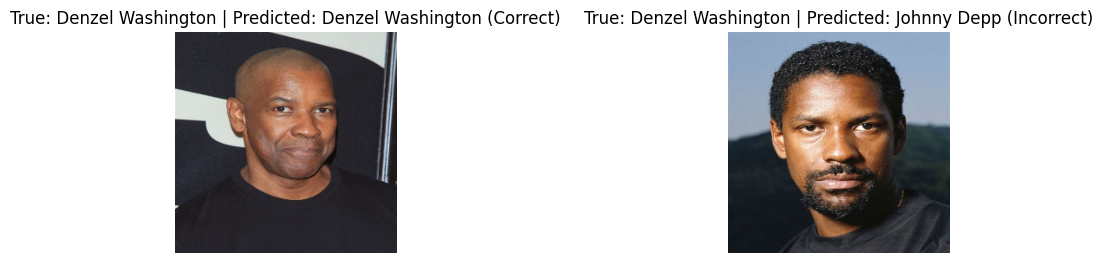

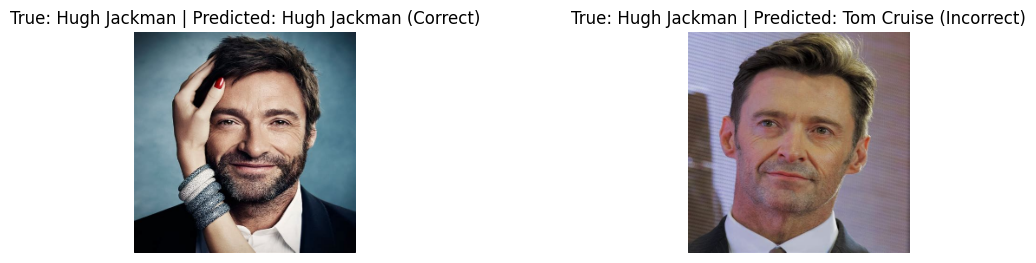

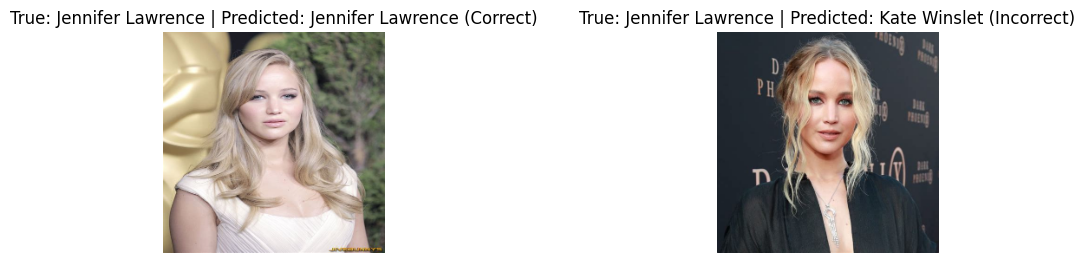

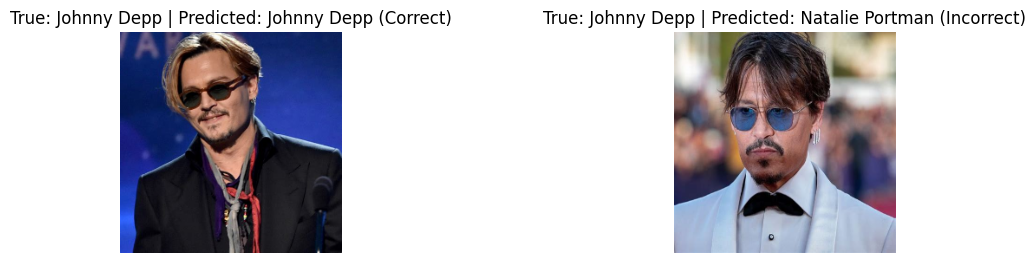

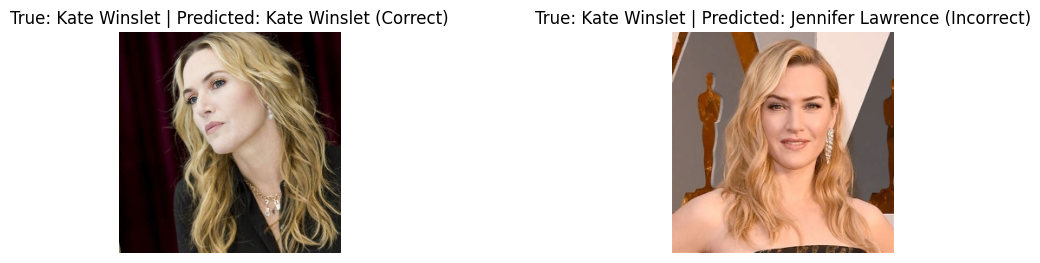

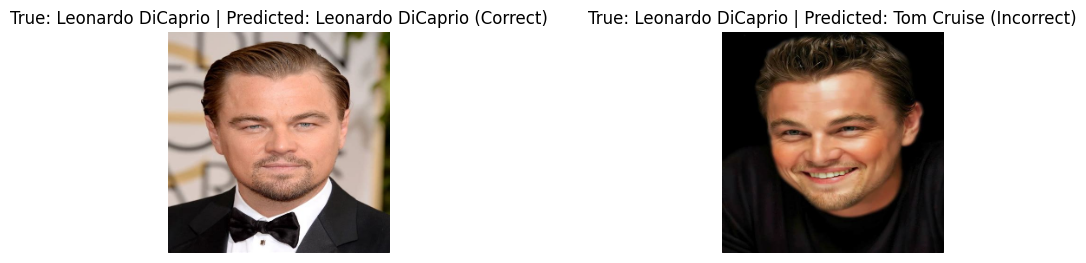

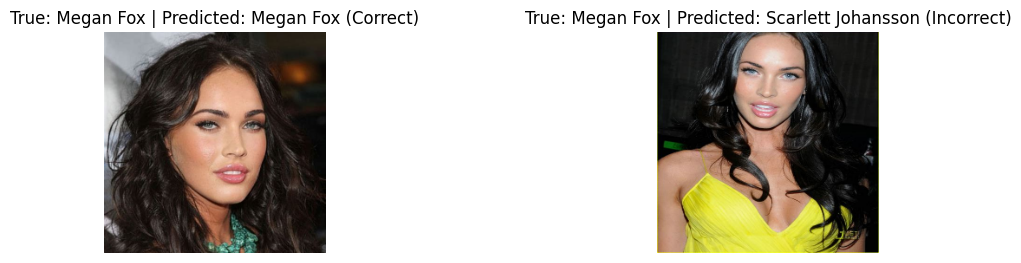

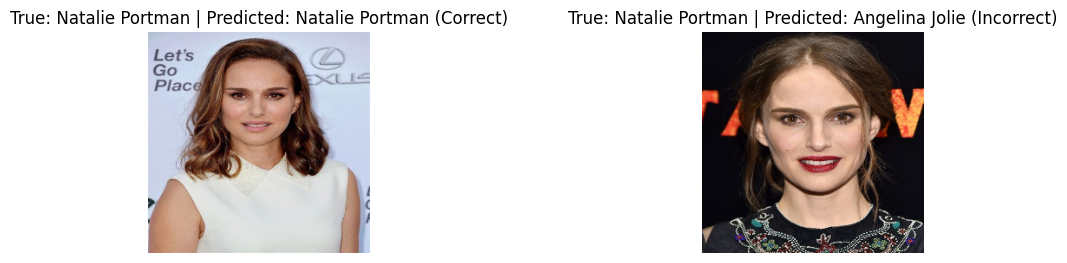

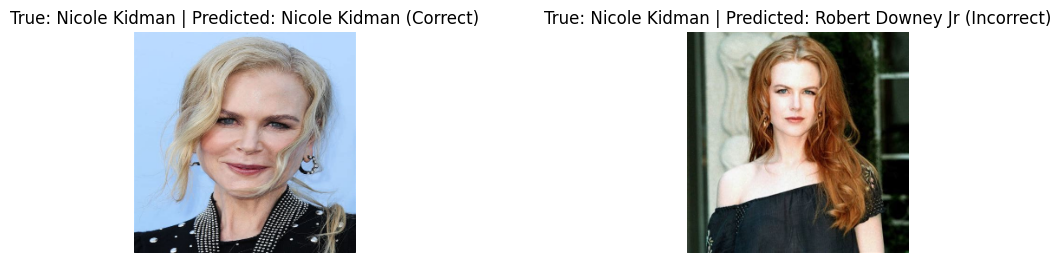

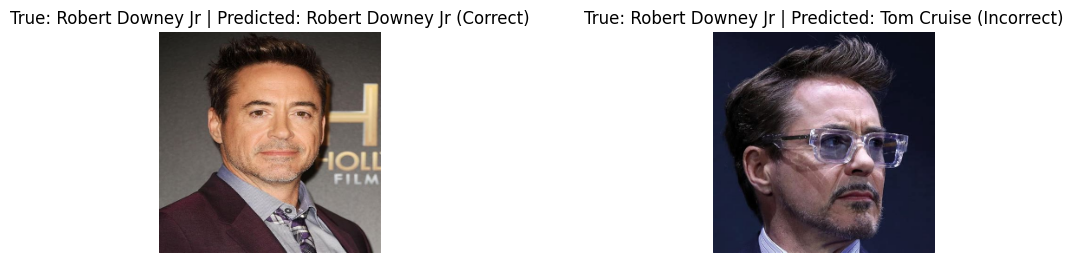

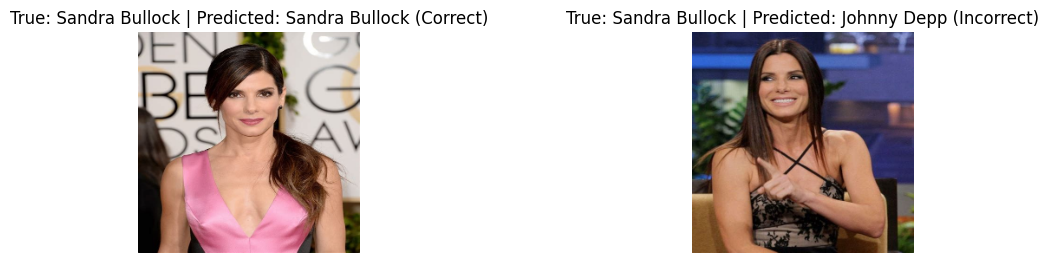

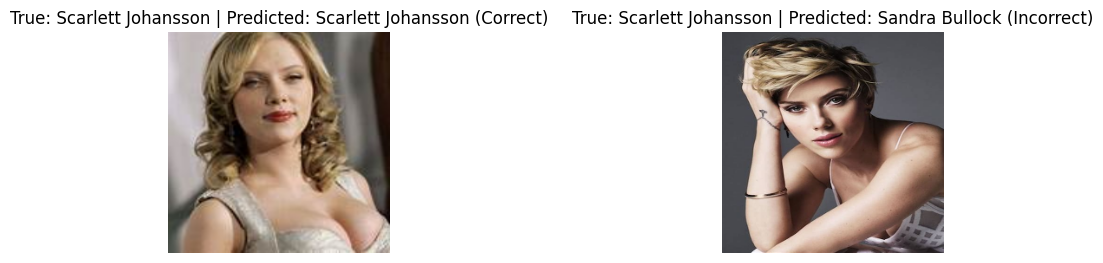

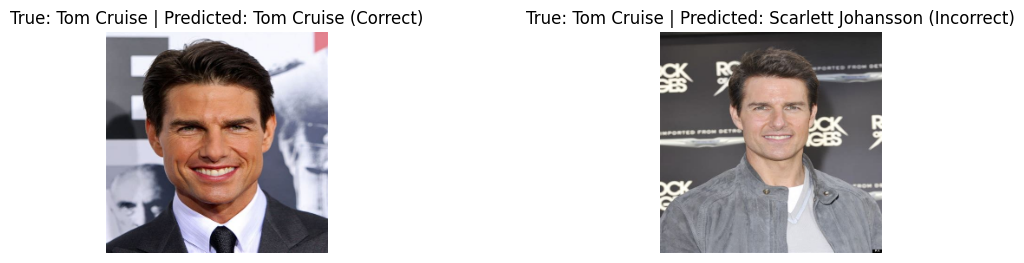

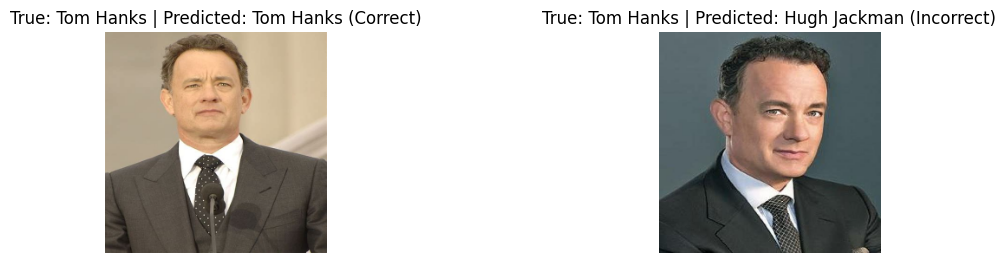

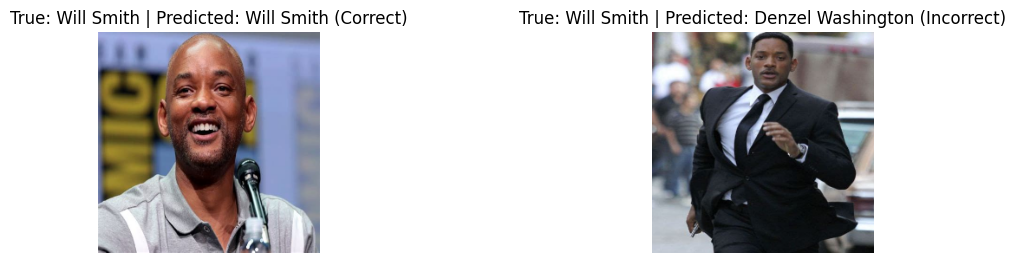

In [21]:
if last_y_test is not None and last_y_pred is not None:

    # (C) Show exactly 1 correct and 1 incorrect prediction for each label (if available)
    unique_labels = np.unique(last_y_test)
    for lbl in unique_labels:
        # indices for this label
        lbl_indices = np.where(last_y_test == lbl)[0]

        # among these, figure out which are correct and incorrect
        correct_mask = (last_y_pred[lbl_indices] == lbl)
        incorrect_mask = ~correct_mask

        correct_indices = lbl_indices[np.where(correct_mask)[0]]
        incorrect_indices = lbl_indices[np.where(incorrect_mask)[0]]

        # Show 1 correct example if available
        if len(correct_indices) > 0:
            idx = correct_indices[0]
            img_rgb = X_color[last_test_indices[idx]]
            pred_label = last_y_pred[idx]
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.title(f"True: {label_map[lbl]} | Predicted: {label_map[pred_label]} (Correct)")
            plt.axis("off")

        # Show 1 incorrect example if available
        if len(incorrect_indices) > 0:
            idx = incorrect_indices[0]
            img_rgb = X_color[last_test_indices[idx]]
            pred_label = last_y_pred[idx]
            plt.subplot(1, 2, 2)
            plt.imshow(img_rgb)
            plt.title(f"True: {label_map[lbl]} | Predicted: {label_map[pred_label]} (Incorrect)")
            plt.axis("off")
        plt.subplots_adjust(wspace=1.5)
        plt.show()